In [3]:
from Bio.Seq import Seq
from pathlib import Path
import pandas as pd
import re

raw_data = Path("../raw_data")
processed_data = Path("../processed_data")

ref_fasta_path = raw_data / "avGFP_reference_sequence.fa"
mutations_aa_csv = raw_data / "amino_acid_genotypes_to_brightness.tsv"
gfp_features_csv = processed_data / "gfp_features.csv"
output_fasta = processed_data / "mutated_sequences.fasta"

In [4]:
with open(ref_fasta_path) as handle:
    dna_seq = next(line.strip() for line in handle if not line.startswith('>'))
# dna_seq.lower()

protein_seq = str(Seq(dna_seq).translate())
protein_seq

'SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*'

In [5]:
# --- GENERATE MUTATED SEQUENCES ----

def process_mutations(protein_seq, mutations):
    # Return original sequence if mutations is not a string
    if not isinstance(mutations, str):
        return protein_seq
    pattern = r"S([A-Z])(\d+)([A-Z\*])"
    mutated_seq = list(protein_seq)
    for match in re.finditer(pattern, mutations):
        original_res, position, mutated_res = match.groups()
        pos = int(position)
        if original_res == mutated_seq[pos]:
            mutated_seq[pos] = mutated_res
        else:
            print(f"original_res: `{original_res}` dosn't match")
    return "".join(mutated_seq)

df = pd.read_csv(mutations_aa_csv, sep="\t")
df["mutated_seq"] = df["aaMutations"].apply(lambda x: process_mutations(protein_seq, x))
df["mutated_seq"] = "M" + df["mutated_seq"].str.split("*").str[0]

# Remove rows where stop codon has been inserted
original_length = len(protein_seq)
df = df[df["mutated_seq"].str.len() >= original_length]

# Keep only unique mutated sequences
df_unique = df.drop_duplicates(subset="mutated_seq")


df_unique.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,mutated_seq
0,NaN,3645,3.719212,0.106992,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


Mean Median Brightness: 2.66
Median of Median Brightness: 3.29
Standard Deviation of Median Brightness: 1.06
Minimum Median Brightness: 1.28
Maximum Median Brightness: 4.12


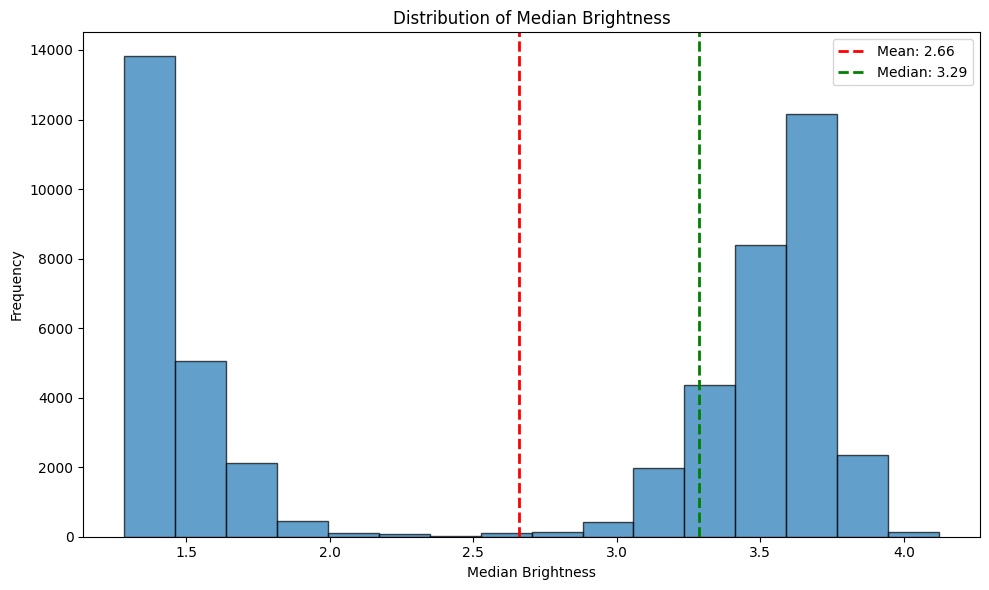

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Create the histogram
plt.figure(figsize=(10, 6))

# Calculate the number of bins using Sturges' rule
num_bins = int(np.log2(len(df_unique)) + 1)

n, bins, patches = plt.hist(df_unique['medianBrightness'], bins=num_bins,
                            edgecolor='black', alpha=0.7)

plt.title('Distribution of Median Brightness')
plt.xlabel('Median Brightness')
plt.ylabel('Frequency')

# Add vertical line for mean
mean_brightness = df_unique['medianBrightness'].mean()
plt.axvline(mean_brightness, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_brightness:.2f}')

# Add vertical line for median
median_brightness = df_unique['medianBrightness'].median()
plt.axvline(median_brightness, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_brightness:.2f}')

plt.legend()

# Improve layout
plt.tight_layout()

# Save the plot
# plt.savefig('median_brightness_histogram.png', dpi=300)
# plt.close()

# Print some statistics
print(f"Mean Median Brightness: {mean_brightness:.2f}")
print(f"Median of Median Brightness: {median_brightness:.2f}")
print(f"Standard Deviation of Median Brightness: {df_unique['medianBrightness'].std():.2f}")
print(f"Minimum Median Brightness: {df_unique['medianBrightness'].min():.2f}")
print(f"Maximum Median Brightness: {df_unique['medianBrightness'].max():.2f}")

In [7]:
# --- CREATE BRIGHTNESS CATEGORIES ---

# Assuming df_unique is your processed dataframe
# If not, you may need to load your dataframe here

# Define the native brightness
native_brightness = 3.7192121319

# Define the number of categories
num_categories = 10

# Calculate the range of brightness values
min_brightness = df_unique['medianBrightness'].min()
max_brightness = df_unique['medianBrightness'].max()

# Create category boundaries
boundaries = np.linspace(min_brightness, max_brightness, num_categories + 1)

# Create category labels
labels = [f'Cat {i+1}' for i in range(num_categories)]

# Add a category column to the dataframe
df_unique['brightness_category'] = pd.cut(df_unique['medianBrightness'], bins=boundaries, labels=labels, include_lowest=True)

# Function to get the native category
def get_native_category(native_brightness, boundaries, labels):
    for i, (lower, upper) in enumerate(zip(boundaries[:-1], boundaries[1:])):
        if lower <= native_brightness < upper:
            return labels[i]
    return 'Unknown'

native_category = get_native_category(native_brightness, boundaries, labels)

# Print category information
print("Brightness categories:")
for i, (lower, upper) in enumerate(zip(boundaries[:-1], boundaries[1:])):
    print(f"{labels[i]}: {lower:.2f} to {upper:.2f}")

print(f"\nNative brightness ({native_brightness:.2f}) falls in category: {native_category}")

# Print some statistics about the categories
category_counts = df_unique['brightness_category'].value_counts().sort_index()
print("\nNumber of sequences in each category:")
print(category_counts)

# Optionally, save the updated dataframe
# df_unique.to_csv('categorized_brightness_data.csv', index=False)

print("\nCategories have been added to the dataframe in the 'brightness_category' column.")

Brightness categories:
Cat 1: 1.28 to 1.57
Cat 2: 1.57 to 1.85
Cat 3: 1.85 to 2.14
Cat 4: 2.14 to 2.42
Cat 5: 2.42 to 2.70
Cat 6: 2.70 to 2.99
Cat 7: 2.99 to 3.27
Cat 8: 3.27 to 3.56
Cat 9: 3.56 to 3.84
Cat 10: 3.84 to 4.12

Native brightness (3.72) falls in category: Cat 9

Number of sequences in each category:
brightness_category
Cat 1     16950
Cat 2      4131
Cat 3       415
Cat 4       117
Cat 5       127
Cat 6       363
Cat 7      3493
Cat 8      9150
Cat 9     16173
Cat 10      796
Name: count, dtype: int64

Categories have been added to the dataframe in the 'brightness_category' column.


In [8]:
# --- PREPARE CSV FILE FOR PROTSPACE ---

def count_mutations(mutations):
    if pd.isna(mutations):
        return 0
    return f"a{len(mutations.split(':'))}"

# Create a new dataframe with the required columns
df_transformed = pd.DataFrame({
    'identifier': df_unique['aaMutations'].fillna('P42212'),
    'brightness_category': df_unique['brightness_category'],
    'nr_mutations': df_unique['aaMutations'].apply(count_mutations)
})

# Display the first few rows of the transformed dataframe
print(df_transformed.head())
df_transformed.to_csv(gfp_features_csv, index=False)


                           identifier brightness_category nr_mutations
0                              P42212               Cat 9            0
1                              SA108D               Cat 1           a1
2  SA108D:SN144D:SI186V:SM231T:SL234P               Cat 1           a5
3         SA108D:SY141N:SH146L:SE220G               Cat 1           a4
4                              SA108G               Cat 9           a1


In [9]:
# --- SAVE FASTA FILE ---

def create_fasta_file(df, output_file, protein_seq):
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            if pd.isna(row['aaMutations']):
                header = ">P42212"
                sequence = protein_seq
            else:
                header = f">{row['aaMutations']}"
                sequence = row['mutated_seq']

            f.write(f"{header}\n")
            f.write(f"{sequence}\n")

# Create the FASTA file
create_fasta_file(df_unique, output_fasta, protein_seq)

print(f"FASTA file '{output_fasta}' has been created.")

FASTA file 'mutated_sequences.fasta' has been created.


## Subset ProtT5 embeddings

In [10]:
import h5py
from Bio import SeqIO

def subset_h5_by_fasta(fasta_file, h5_file, output_h5):
    """
    Subsets an H5 file based on headers found in a FASTA file.

    Parameters:
    fasta_file (str): Path to input FASTA file
    h5_file (str): Path to input H5 file
    output_h5 (str): Path to output H5 file
    """
    # Read FASTA headers into a set
    fasta_headers = {record.id for record in SeqIO.parse(fasta_file, "fasta")}

    # Open input and output H5 files
    with h5py.File(h5_file, 'r') as h5_in, h5py.File(output_h5, 'w') as h5_out:
        # Iterate through datasets in input H5
        for dataset_name in h5_in.keys():
            if dataset_name in fasta_headers:
                # Copy matching datasets to output H5
                h5_in.copy(dataset_name, h5_out)

fasta_file = "../processed_data/subset_1000.fasta"
h5_file_full = "../processed_data/prott5.h5"
h5_file_subset = "../processed_data/prott5_embs_subset_1000.h5"
subset_h5_by_fasta(
    fasta_file=fasta_file,
    h5_file=h5_file_full,
    output_h5=h5_file_subset
    )